# Introduction

The Kaggle competition [Toxic Comment Classification](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge) challenges competitors to identify toxic language in Wikipedia comments.
The competition concluded in March 2018, four months ago, so I am not participating.

The competition considers six types of toxicity:
* toxic
* severe_toxic
* obscene
* threat
* insult
* identity_hate

A comment can be labeled as more than one type of toxicity, or none. 
The data provided as training and test data has been labeled by humans.

# The data set

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline

In [3]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

In [4]:
print("Traing data samples:" , len(train_data))
print("Test data samples:" , len(test_data))

Traing data samples: 159571
Test data samples: 153164


Sweet, there really is a lot of data to work with. 
Almost 160K comments in the training data.

In [5]:
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Each row has an ID, a comment text, and labels for all six toxicity types.
I will only be using the `comment_text` as a feature.

Before proceeding with any exploratory data analysis (EDA), let's set aside a validation / dev set.

In [6]:
from sklearn.model_selection import train_test_split

There does not seem to be a solid way of stratifying mutilabel data, so let's hope that using a large enough test set gives similar distributions.

In [7]:
train_df, dev_df = train_test_split(train_data, test_size = .3, random_state=0, shuffle=True)

Verify if the frequency of each toxicity type is the same in the validation and training set.

In [8]:
# Set up a temporary data frame with both data sets included, but with labels
df1 = train_df.copy()
df2 = dev_df.copy()

df1['data_set'] = 'train'
df2['data_set'] = 'dev'

df = pd.concat([df1, df2])

# Melt the labels and count ocurences of each type
df = pd.melt(df.drop(['id', 'comment_text'], 1), id_vars='data_set', var_name='toxicity_type', value_name='occurences')
df = df.groupby(['data_set', 'toxicity_type']).agg('sum').reset_index()

# Normalize occurences per data set
df.loc[df['data_set'] == 'train', 'occurences'] = df.loc[df['data_set'] == 'train', 'occurences'] / len(df1)
df.loc[df['data_set'] == 'dev', 'occurences'] = df.loc[df['data_set'] == 'dev', 'occurences'] / len(df2)

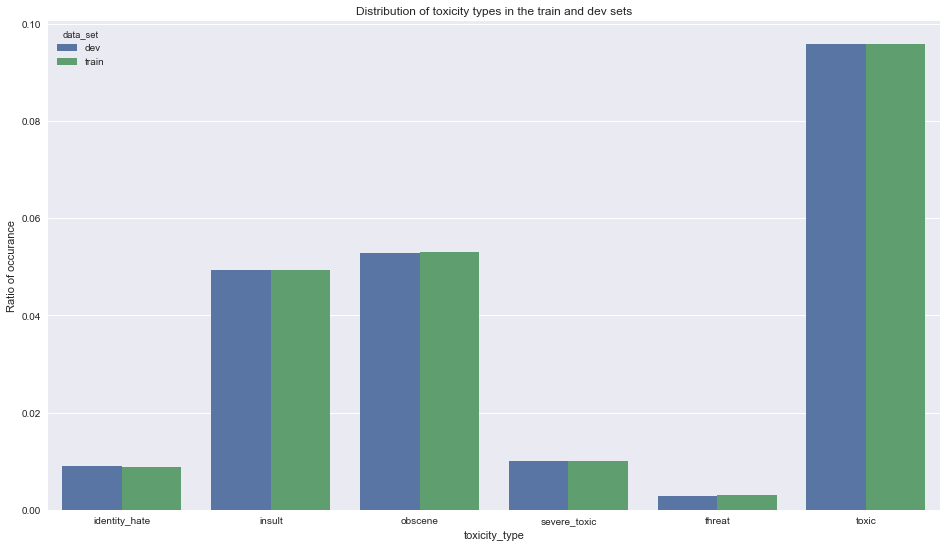

In [9]:
f, ax = plt.subplots(figsize=(16,9))
sns.barplot(x='toxicity_type', y='occurences', hue = 'data_set', data=df, ax=ax)
ax.set_title('Distribution of toxicity types in the train and dev sets')
ax.set_ylabel('Ratio of occurance')

All types occur in a similar amount of comments for both data sets. Great!

Now let's not look at the validation set any more.

# Exploratory data analysis

## Correlation of toxicity types
It seems likely that some toxicity types often occur together. Let's have a look at how they correlate.

In [10]:
import numpy as np

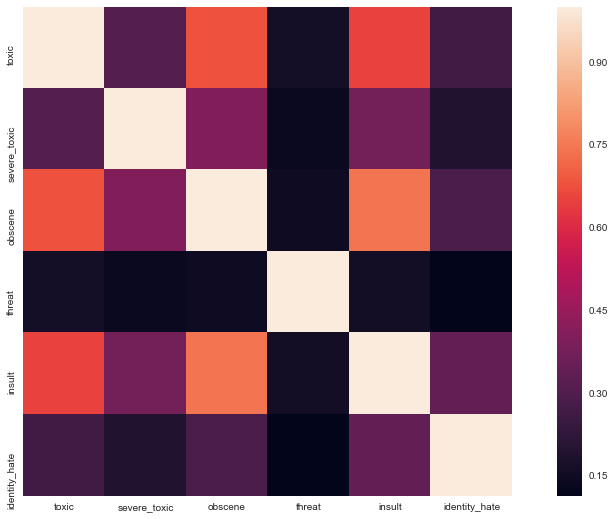

In [11]:
f, ax= plt.subplots(figsize=(16,9))
sns.heatmap(train_df.iloc[:,-6:].corr(), square=True)

The strongest pairwise correlations seems to be between `insult` and `obscene`, `toxic` and `obcene` as well as `toxic` and `insult`.
Seems like people like to mix all of these three!

The correlation of `toxic` and `severe_toxic` is relatively low, even though you would expect all `severe_toxic` comments to also be `toxic`.
This is most likely because there are far more `toxic` comments.
It would be interesting to know if some types often imply another, for example I expect P(`severe_toxic` | `toxic`) to be high.

I will not derail down this path any further though, as I won't have access to any of the label when doing classification anyway.

## Text properties of comments

### Characters

In [12]:
train_df['comment_length'] = train_df['comment_text'].apply(len)

C:\Users\Gustav\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [13]:
train_df['comment_length'].describe()

count    111699.000000
mean        395.161040
std         591.699054
min           6.000000
25%          96.000000
50%         205.000000
75%         437.000000
max        5000.000000
Name: comment_length, dtype: float64

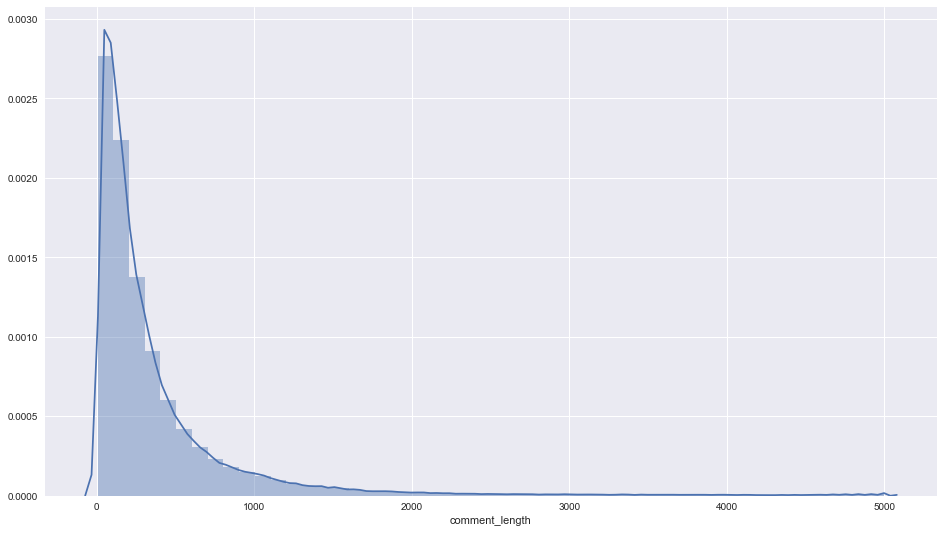

In [14]:
f, ax = plt.subplots(figsize=(16,9))
sns.distplot(train_df['comment_length'])

Some comments are really long, the longest is 5000 characters and 25% are longer than 400 characters.

### Words

I will not bother splitting the comments into sentences before doing word tokenization.

In [15]:
from nltk import word_tokenize

In [16]:
train_df['tokenized_comment'] = train_df['comment_text'].apply(word_tokenize)

C:\Users\Gustav\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [17]:
train_df['tokenized_comment_length'] = train_df['tokenized_comment'].apply(len)

C:\Users\Gustav\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [18]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_length,tokenized_comment,tokenized_comment_length
104158,2d59e577d6d081da,"Actually you know what, I'm not using this acc...",0,0,0,0,0,0,226,"[Actually, you, know, what, ,, I, 'm, not, usi...",52
81146,d90eed2c03efb2b0,"""\n\nThe problem with this disambig is, Michae...",0,0,0,0,0,0,619,"[``, The, problem, with, this, disambig, is, ,...",131
6248,10af179019d6d9b8,"""\n\nLegalleft, I just guess sarcasm is not on...",0,0,0,0,0,0,150,"[``, Legalleft, ,, I, just, guess, sarcasm, is...",26
36126,6088014ca4f31017,Please note that you have no right to free spe...,0,0,0,0,0,0,116,"[Please, note, that, you, have, no, right, to,...",25
70143,bb9fc7e55e51f62f,"""\n\nBoba Phat at AFD again\nAn AFD you partic...",0,0,0,0,0,0,181,"[``, Boba, Phat, at, AFD, again, An, AFD, you,...",31


In [19]:
train_df['tokenized_comment_length'].describe()

count    111699.000000
mean         80.555368
std         121.201846
min           1.000000
25%          20.000000
50%          43.000000
75%          89.000000
max        4849.000000
Name: tokenized_comment_length, dtype: float64

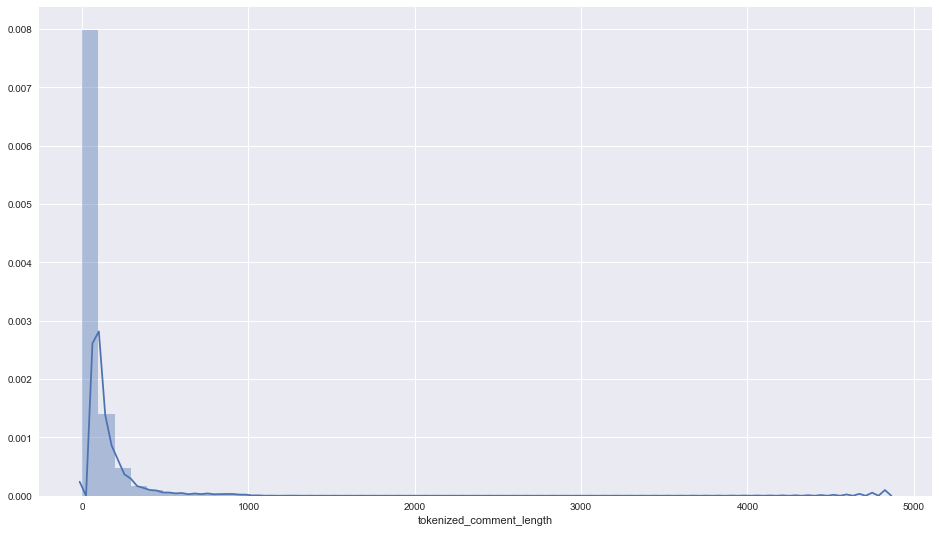

In [20]:
f, ax = plt.subplots(figsize=(16,9))
sns.distplot(train_df['tokenized_comment_length'])

The average comment is about 80 word tokens long, the longest one is almost 5000...

In [21]:
train_df.sort_values('tokenized_comment_length', ascending=False).iloc[0]['comment_text']

"why don't you suck my ass until your lips bleed? \n\nCONGRATS!  NOW YOU'VE LOST A GOOD ARTICLE AS WELL AS A READER!  I WILL NEVER COME BACK TO WIKISHIT AGAIN!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Aha, thousands of repeated exclamation marks. 
I could atempt removing repeated occurances of the same token, and possibly create a new feature based on this. 
It seems likely that a message with many exclamation marks is one written in rage, and therefore possibly toxic.

### Words in all caps
A typical strategy to convey shouting or anger in text is the use of ALL CAPS. 
Let's see if these messages are often toxic.

In [22]:
def all_caps_ratio(text):
    # I will only count tokens that are longer than one character 
    # in the hopes of excluding punctuation and single letter words like a
    word_counter = all_caps_counter = 0
    
    for word in text:
        if len(word) == 1:
            pass
        elif word == word.upper():
            word_counter += 1
            all_caps_counter += 1
        else:
            word_counter += 1
    return all_caps_counter / word_counter if word_counter > 0 else 0
    

In [23]:
train_df['all_caps_ratio'] = train_df['tokenized_comment'].apply(all_caps_ratio)

C:\Users\Gustav\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [24]:
train_df['all_caps_ratio_binned'] = pd.cut(train_df['all_caps_ratio'], 20)

C:\Users\Gustav\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [25]:
toxicity_types = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

Count the number of occurences in each type per bin, as well as the total number of occurences in the bin by using `id`.

In [26]:
df = train_df.groupby('all_caps_ratio_binned').agg({
                                        'identity_hate': 'sum',
                                        'insult': 'sum',
                                        'obscene': 'sum',
                                        'severe_toxic': 'sum',
                                        'threat': 'sum',
                                        'toxic': 'sum',
                                        'id' : 'count'})

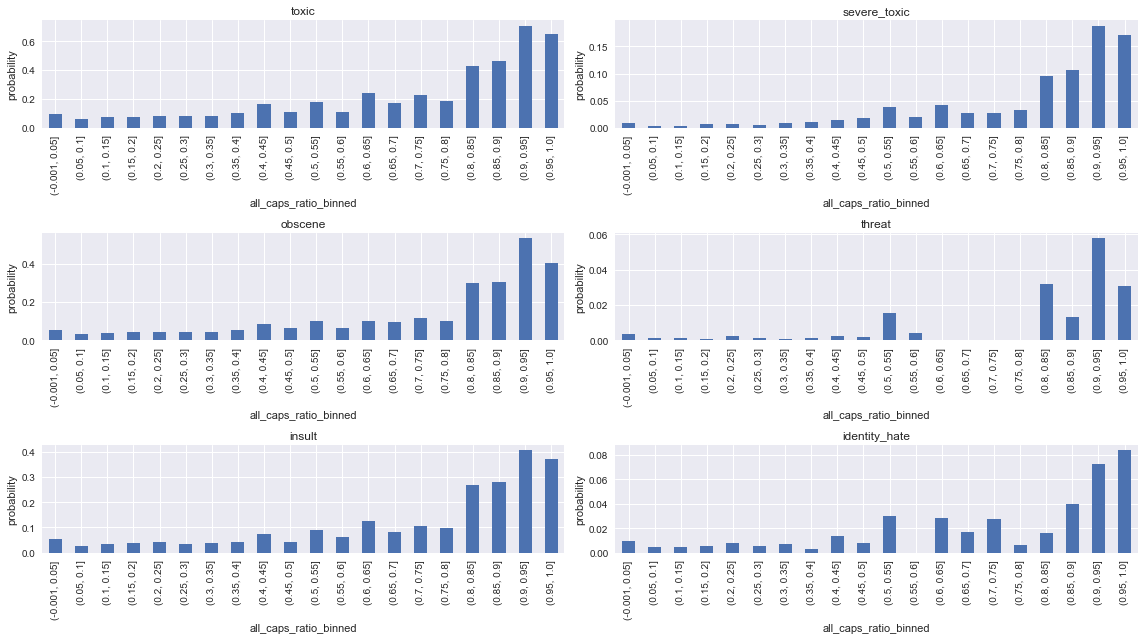

In [27]:
f, ax = plt.subplots(len(toxicity_types) // 2, 2, figsize=(16,9))
ax=ax.flatten()
for i, tox in enumerate(toxicity_types):
    (df[tox] / df['id']).plot(kind='bar', ax=ax[i])
    ax[i].set_title(tox)
    ax[i].set_ylabel('probability')
f.tight_layout()

Most forms of toxicity are far more likely to have occured if the message was mostly written in capital letters.
I have normalised with number of total occurences per bin, and we can for example see that if a message is written with 95-100% capital letters it is with over 60% probabilty toxic.

The ratio of all caps seems like a promising feature for classification.

## Vocabulary Size

In [28]:
dictionary = {}
for i, row in train_df.iterrows():
    # Only count 1 occurance per mail
    for word in set(row['tokenized_comment']):
        try:
            dictionary[word] +=1
        except KeyError:
            dictionary[word] = 1

In [29]:
print("{} unique words in the training data".format(len(dictionary)))

241957 unique words in the training data


In [30]:
dictionary_df = pd.DataFrame.from_dict(data=dictionary, orient='index').reset_index().rename(columns={0 : 'occurrences', 'index' : 'word'})

In [31]:
df = dictionary_df.groupby('occurrences').agg('count')

In [32]:
df['cumsum'] = df['word'][::-1].cumsum()#/ df['word'].sum()

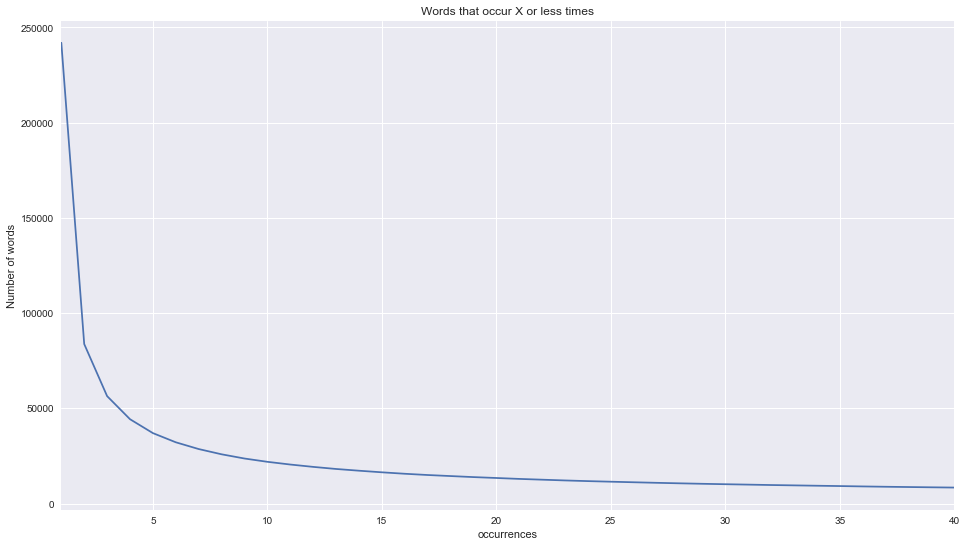

In [33]:
f, ax = plt.subplots(figsize=(16,9))
df['cumsum'][:40].plot(ax=ax)
ax.set_title('Words that occur X or less times')
ax.set_ylabel('Number of words')

In [34]:
df.head(10)

,word,cumsum
occurrences,,
1,158213,241957
2,27350,83744
3,12122,56394
4,7302,44272
5,4819,36970
6,3551,32151
7,2757,28600
8,2214,25843
9,1732,23629


Only aroud 22K words appear 10 or more times.

## Most common words?

In [35]:
dictionary_df.sort_values('occurrences', ascending=False).head(10)

,word,occurrences
15,.,89968
28,",",75307
40,the,72179
34,to,65603
19,I,56457
35,a,55756
6,and,54329
83,of,53057
20,is,50078
2,you,48813


Punctuation and stop words are the most common tokens. 
I can probably ignore these during classification.

### Most common words per toxicity type

In [36]:
class_dicts = {}

In [37]:
for tox in toxicity_types:
    class_dicts[tox] = {}
    for i, row in train_df[train_df[tox] == 1].iterrows():
        # Only count 1 occurance per mail
        for word in set(row['tokenized_comment']):
            try:
                class_dicts[tox][word] +=1
            except KeyError:
                class_dicts[tox][word] = 1

In [47]:
from nltk.corpus import stopwords
stopwords_eng = stopwords.words('english')

In [51]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [52]:
stopwords_eng += [c for c in string.punctuation]

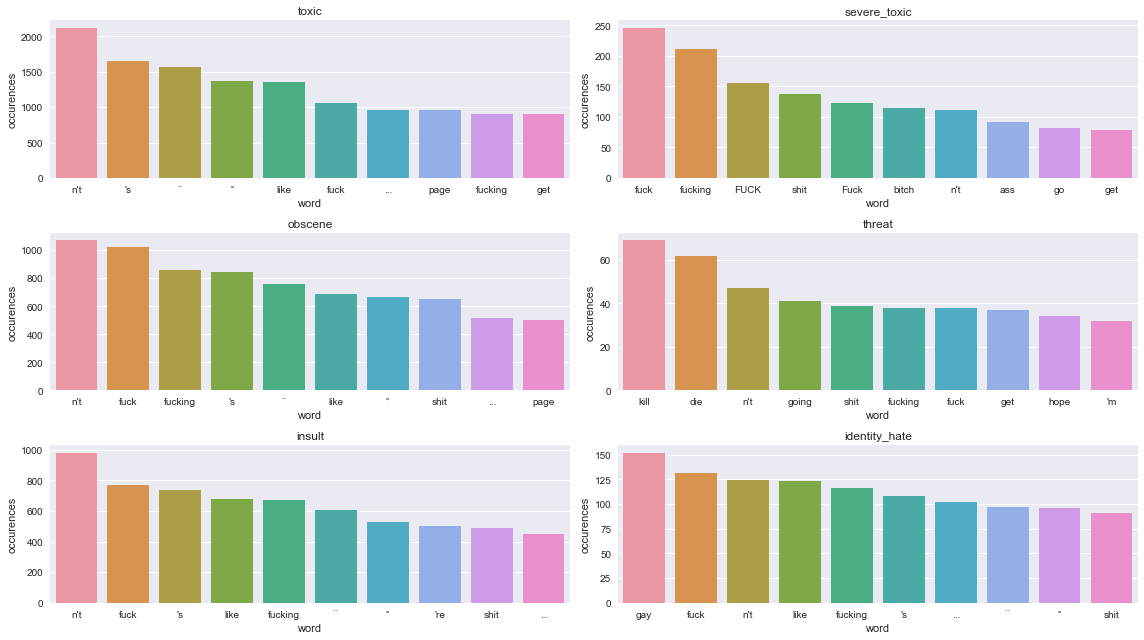

In [53]:
f, ax = plt.subplots(3, 2, figsize=(16,9))
ax=ax.flatten()
for i, tox in enumerate(toxicity_types):
    df = pd.DataFrame.from_dict(class_dicts[tox], orient='index').reset_index().rename(columns={0 : 'occurrences', 'index' : 'word'})
    df = df.sort_values('occurrences', ascending=False)
    df = df[df['word'].apply(lambda x: x.lower() not in stopwords_eng)]
    sns.barplot(x='word', y = 'occurrences', data=df[:10], ax=ax[i])
    ax[i].set_title(tox)
    ax[i].set_ylabel('occurences')
f.tight_layout()

I see a lot of bad words here, but it is also apparent that my tokenization is not optimal. 
I should consider first converting words like `don't` to `do not` etc. to avoid tokens like `n't` and `'s`. 
Perhaps it would even be a good idea to do lemmatization? 

I will have to revisit my preprocessing.